# FASTQ processing script

This notebook will take FASTQ files from Ribo-seq or RNA-seq and convert them to density files aligned to a genome using the 3' end of genes. 

- Filtering is done using skewer v0.2.2 to remove low quality reads and reads outside of size threshold.
- Bowtie v0.12.7 removes any contaminating ladder, tRNA, and rRNA. Aligns reads with an allowed mismatch of 2.
- Density is made using 3' alignment. It is stored as a pickled dictionary and is size separated. It is also saved as a .wig file and a .bin file for convenience. 
- Script will output library statistics including filtering and bowtie read allocation, as well as some custom QC information. 

Generally, I save this script as an HTML file alongside the density file for reference.

Input and paths are placed in dictionaries. Libraries are numbered as initials + library number (FM1, FM2...)

In [1]:
%load_ext autoreload
%autoreload 2
import ribo_util
import ribo_main
import ribo_analysis
import ribo_plot



'''Settings and Inputs'''

library_creator = 'FM'        #FM, KS, CW, Menkin, Li, etc... (initial of who made it)
organism        = 'Coli'      #Coli, Subtilis, Tuberculosis etc...

inputs = {
    
    'files' : [library_creator + str(i) for i in range(94, 107)],       #Files to analyze
    
    # for data renaming: useful to rename files from seq_facility - can be ignored
    'order_name' : 'abuskir1_149005_FM94_106',    # to rename/concat FASTQ if needed, else set to 'none' or ignore
    
    # select which functions to run: 'yes' and 'no' 
    'run_filtering': 'yes',
    'run_bowtie'   : 'yes',
    'run_density'  : 'yes',
    'run_readQC'   : 'yes',
    
    # cuttoff for readsize and quality for filtering and density
    'minlength'    : 10,
    'maxlength'    : 40,
    'phred_cutoff' : 10,
                        
    # linker-1 for FM = CTGTAGGCACCATCAATAGATCGGAAGAGCACACGTCTGAACTCCAGTCA
    # for SM          = CTGTAGGCACCATCAATTCGTATGCCGTCTTCTGCTTG
    # Gross           = CTGTAGGCACCATCAATATCTCGTATGCCGTCTTCTGCTTG
    # Zoya            = ATCTCGTATGCCGTCTTCTGCTTG
    'linker'       :   'CTGTAGGCACCATCAATAGATCGGAAGAGCACACGTCTGAACTCCAGTCA',
                      
    
    # CPU information for multithreading applications, 
    'multiprocess' : 'yes',
    'threads'      : 8,
    'cores'        : 4, 
    
    }

'''Input directories'''
# Can be customized to your liking 

path_pc     = '/Volumes/HDD/Ribo_seq/'
inpath      = path_pc + 'libraries/'
path_script = '/Users/fuad/Dropbox/'

paths_in = {
    'fastq_download' : inpath  + 'FASTQ/downloaded/',
    'path_fastq'     : inpath  + 'FASTQ/' + library_creator + '/',
    'path_gff'       : path_pc + 'annotations/'+organism+'/'+organism+'.gff',
    'path_gff_dict'  : path_pc + 'annotations/'+organism+'/'+organism+'_dict',   #will be made from GFF
    'path_bowtie'    : path_script + 'scripts/ribo_seq/bowtie/bowtie',
    'btindex_ladder' : path_script + 'scripts/ribo_seq/bowtie/indexes/ladder/ladder',
    'btindex_trna'   : path_script + 'scripts/ribo_seq/bowtie/indexes/'+organism+'/'+organism+'_tRNA',
    'btindex_rrna'   : path_script + 'scripts/ribo_seq/bowtie/indexes/'+organism+'/'+organism+'_rRNA',
    'btindex_chr'    : path_script + 'scripts/ribo_seq/bowtie/indexes/'+organism+'/'+organism+'_genome',
    }


### Output directories
paths_out = {
    'path_filter'       : inpath  + 'density/filtering_bowtie/filterdata/',
    'path_ladder'       : inpath  + 'density/filtering_bowtie/alignments/ladder/',
    'path_trna'         : inpath  + 'density/filtering_bowtie/alignments/tRNA/',
    'path_rrna'         : inpath  + 'density/filtering_bowtie/alignments/rRNA/',
    'path_chr'          : inpath  + 'density/filtering_bowtie/alignments/chr/',
    'path_temp'         : inpath  + 'density/filtering_bowtie/tmpds/',
    'path_density'      : inpath  + 'density/density/',
    'path_log'          : inpath  + 'density/logs/',
    'path_analysis_log' : inpath  + 'analysis/logs/',
    'path_analysis'     : inpath  + 'analysis/individual/',
    'path_figures'      : inpath  + 'figures/',
    }

gff_settings = {
    'path_out'         : 0,
    'feat_of_interest' : 'protein_coding',         #all, protein_coding, tRNA, rRNA
    'name_qual'        : 'Name',
    'name_qual_alt'    : 'gene_id',
    'biotype_qual'     : 'protein_coding',          #if biotype qualifier NA, biotype_qual = 'all'
    'aSD_seq'          : 'TCCTCC'
    }

# Modify FASTQ files downloaded from server, renaming and concatonating if necessary
ribo_util.rename_FASTQ(inputs, library_creator, paths_in, paths_out)

# Check inputs, create output paths, and make gff dictionary if needed
step = 'density'
ribo_util.check_inputs(inputs, paths_in, step)
ribo_util.createpath(inputs, paths_out)

#ribo_util.GFF_to_dict(paths_in, gff_settings)


Started Fastq renaming at 2018-08-24 11:17:11.000691
FM94 has multuple files, concatonating and renaming
FM95 has multuple files, concatonating and renaming
FM96 has multuple files, concatonating and renaming
FM97 has multuple files, concatonating and renaming
FM98 has multuple files, concatonating and renaming
FM99 has multuple files, concatonating and renaming
FM100 has multuple files, concatonating and renaming
FM101 has multuple files, concatonating and renaming
FM102 has multuple files, concatonating and renaming
FM103 has multuple files, concatonating and renaming
FM104 has multuple files, concatonating and renaming
FM105 has multuple files, concatonating and renaming
FM106 has multuple files, concatonating and renaming

	Finished Fastq renaming at 2018-08-24 11:19:41.450138


In [2]:
filterreads = ribo_main.run_filter(inputs, paths_in, paths_out)
bowtiereads = ribo_main.run_align(inputs, paths_in, paths_out)
densityreads = ribo_main.run_density(inputs, paths_in, paths_out)
analyzereads = ribo_analysis.readQC(inputs, paths_in, paths_out)

-----FILTER-----

Files to filter: FM94, FM95, FM96, FM97, FM98, FM99, FM100, FM101, FM102, FM103, FM104, FM105, FM106
Filter parameters are: 
min length = 10 
max length = 40 
phred cutoff = 10 

	Started filtering at 2018-08-24 11:19:43.176662
	Finished filtering at 2018-08-24 11:23:18.748064
	COMPLETED FILTERING

------ALIGN------

Files to align: FM94, FM95, FM96, FM97, FM98, FM99, FM100, FM101, FM102, FM103, FM104, FM105, FM106

	Started Bowtie alignment at 2018-08-24 11:23:18.750030
	Finished ladder removal at 2018-08-24 11:34:13.311038
	Finished tRNA removal at 2018-08-24 11:57:33.319464
	Finished rRNA removal at 2018-08-24 12:22:53.034680
	Finished chromosome alignment at 2018-08-24 12:38:20.591584
	COMPLETED ALIGNING

-----DENSITY-----

Files to condense: FM94, FM95, FM96, FM97, FM98, FM99, FM100, FM101, FM102, FM103, FM104, FM105, FM106

	Started density at 2018-08-24 12:38:20.593035
	Finished density at 2018-08-24 12:45:07.112742
	COMPLETED DENSITY

	Started readQC at 2018-0

# Read analysis 

Read allocation after filtering and bowtie alignment:

,FM100,FM101,FM102,FM103,FM104,FM105,FM106,FM94,FM95,FM96,FM97,FM98,FM99
total_reads,9834966,10947181,7228578,12046488,9958108,11034896,9582539,17624277,13085882,9919810,9490223,49309001,12192189
filtered_reads,9143437,9705853,6568270,10071217,8939521,10128770,8760951,16391468,9476421,7610380,8888245,42243114,11456139
ladder,46110,26663,16479,114909,133766,20648,11026,34823,26044,36531,33817,301301,109168
tRNA,412702,612301,431142,3116068,1165978,532768,428911,1402474,482800,323824,373895,8107332,744502
rRNA,1681685,1027326,1893626,1921306,4747039,2350867,3253368,5501726,4784221,3255717,2682459,6725784,4418348
chromosome,6315615,7178027,3639661,4179357,2099377,6410788,4296596,7761223,3367101,3440257,4926244,22580435,5261998
% Total mapped,64,65,50,34,21,58,44,44,25,34,51,45,43
unaligned,687325,861536,587362,739577,793361,813699,771050,1691222,816255,554051,871830,4528262,922123


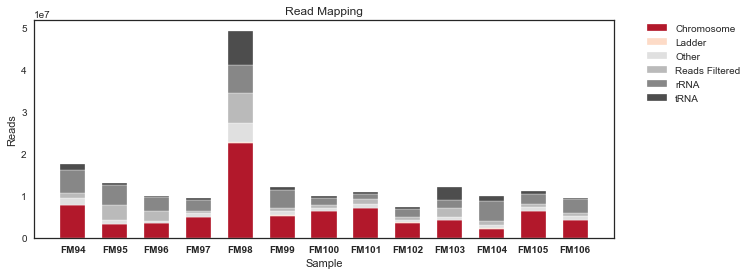

In [3]:
log_data = ribo_util.get_filter_bowtie_log(inputs, paths_in, paths_out)
ribo_plot.plot_alignment_allocation(inputs, paths_in, paths_out)

Read size distribution:

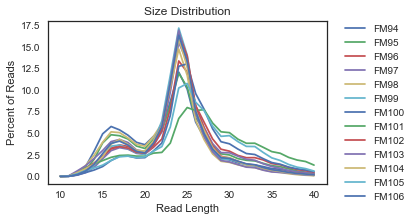

In [4]:
read_size_distribution = ribo_plot.size_dist(inputs, paths_in, paths_out)

Average nucleotide composition of reads:

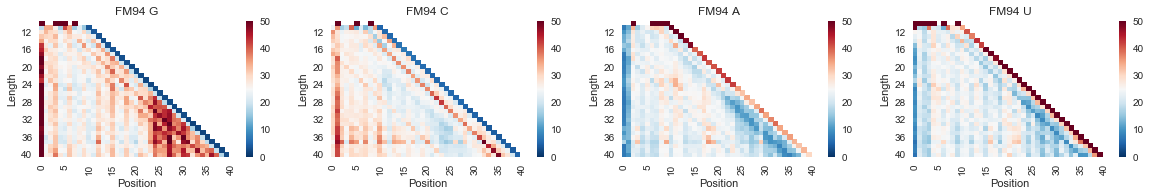

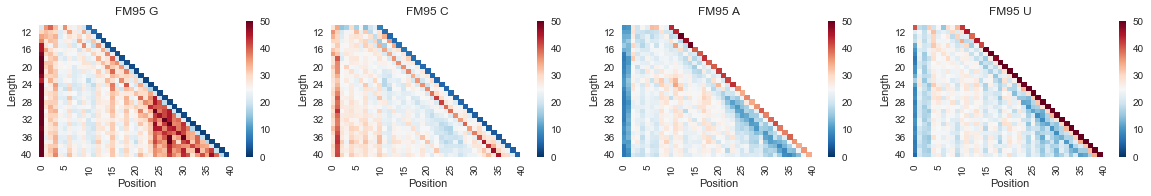

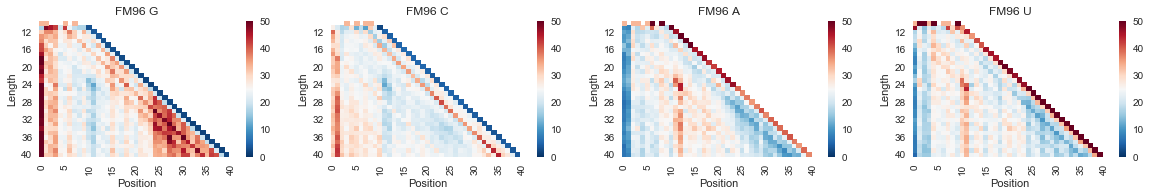

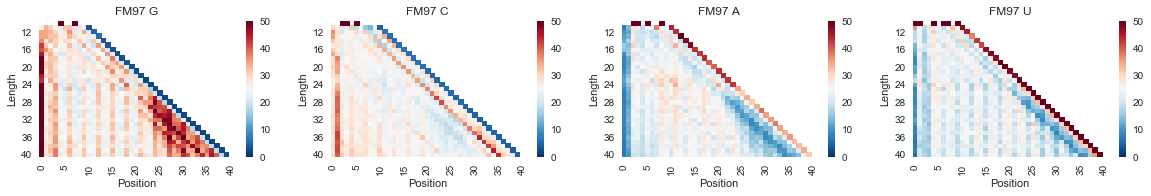

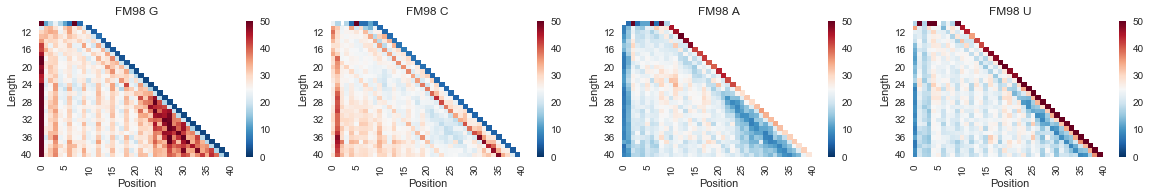

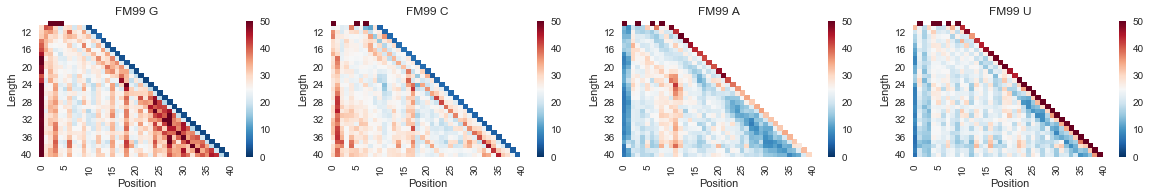

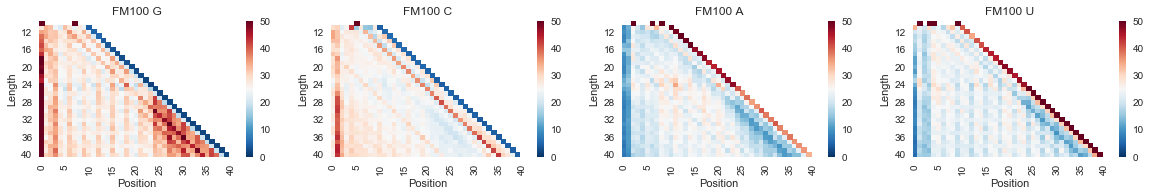

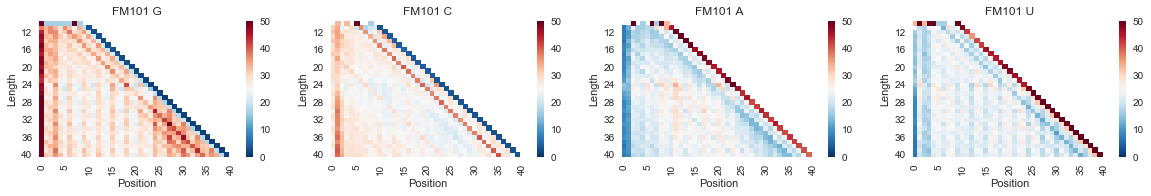

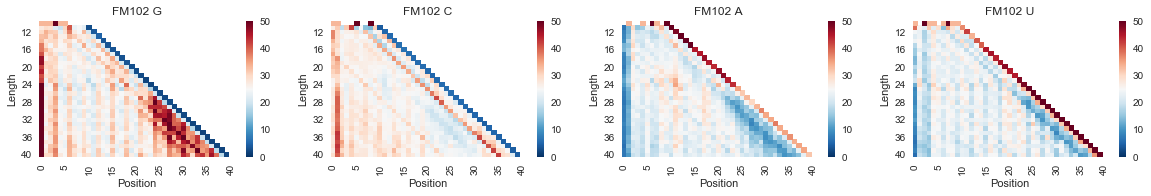

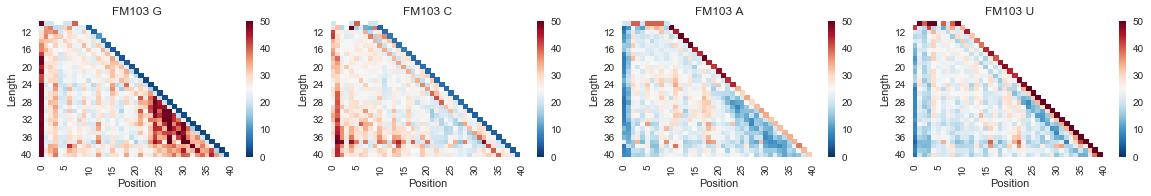

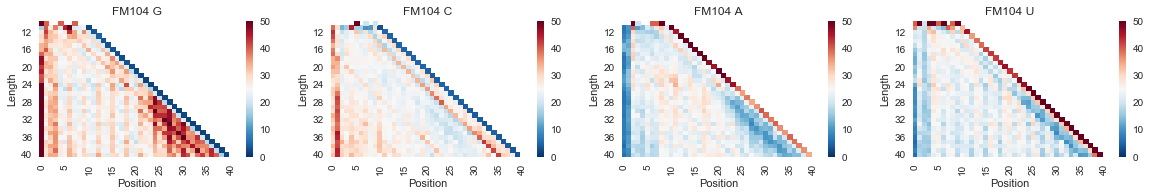

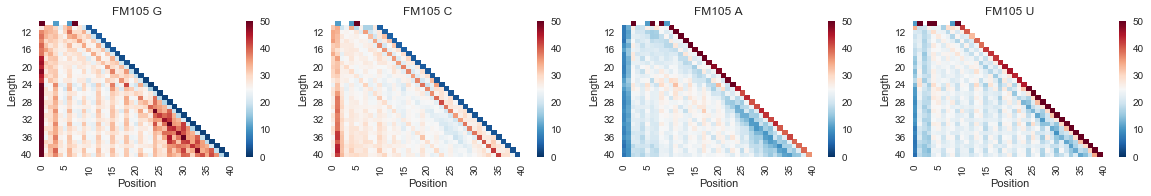

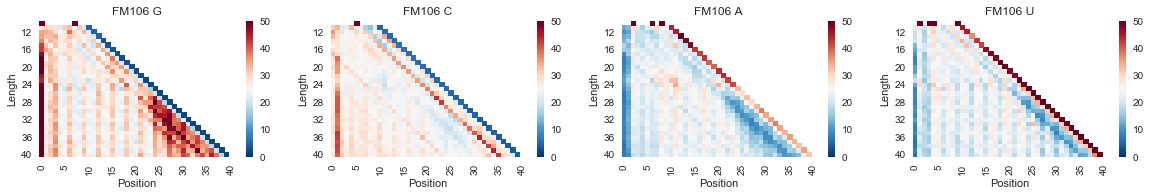

In [5]:
read_composition = ribo_plot.read_comp(inputs, paths_in, paths_out)    